In [1]:
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt
import seaborn as sns

In [30]:
appl = yf.Ticker("AAPL")

hist = appl.history(period="10y")

hist = hist.reset_index()
hist['Date'] = pd.to_datetime(hist['Date'])
hist = hist.sort_values(by='Date', ascending=True)

hist['Year'] = hist['Date'].dt.year
hist['Month'] = hist['Date'].dt.month
hist['Day'] = hist['Date'].dt.day
hist['DayOfWeek'] = hist['Date'].dt.dayofweek
hist['Date'] = hist['Date'].dt.strftime('%Y-%m-%d')

# 移动平均线（技术指标）
hist['SMA_5'] = hist['Close'].rolling(window=5).mean()
hist['SMA_10'] = hist['Close'].rolling(window=10).mean()
hist['SMA_20'] = hist['Close'].rolling(window=20).mean()

# 滞后特征
hist['Close_t-1'] = hist['Close'].shift(1)
hist['Close_t-2'] = hist['Close'].shift(2)
hist['Volume_t-1'] = hist['Volume'].shift(1)

# 收益率特征
hist['Daily_Return'] = hist['Close'].pct_change()

# 构造目标变量（是否上涨：1=上涨，0=不涨）
hist['Target'] = (hist['Close'].shift(-1) > hist['Close']).astype(int)

# 去掉包含NA的行（由于rolling和shift操作产生）
hist.dropna(inplace=True)



In [67]:
# 查看最终特征
# print(hist[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 
#             'SMA_5', 'SMA_10', 'Close_t-1', 'Daily_Return', 'Target']].head())

# 用于机器学习模型的特征列
feature_cols = [
    'Open', 'Volume'
]
# 分离 X 和 y（用于模型训练)
X = hist[feature_cols]
y = hist['Target']



INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


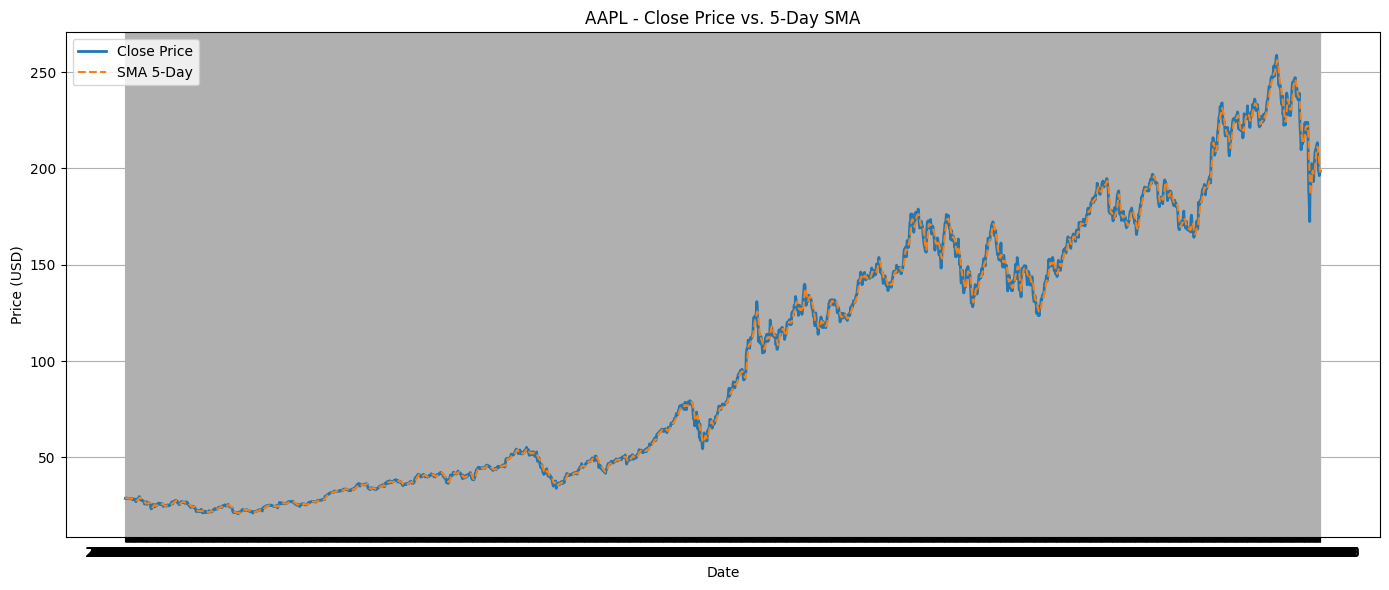

In [62]:
plt.figure(figsize=(14, 6))
plt.plot(hist['Date'], hist['Close'], label='Close Price', linewidth=2)
plt.plot(hist['Date'], hist['SMA_5'], label='SMA 5-Day', linestyle='--')

# 图形美化
plt.title('AAPL - Close Price vs. 5-Day SMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### trainning 

In [37]:
import boto3
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=False  # 时间序列问题 → 不打乱顺序
)

In [69]:
X_train.head()

,Open,Volume
19,28.907176,210699200
20,28.413806,224301600
21,28.687409,156349200
22,28.969967,141563600
23,28.747956,147544800


In [70]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("AAPL_Stock_Prediction")

with mlflow.start_run(run_name="RandomForest_Classifier"):
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # 预测
    y_pred = rf.predict(X_test)

    # 评估模型
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # 记录参数和指标
    mlflow.log_param("n_estimators", 100)
    mlflow.log_metric("accuracy", accuracy)

    # 记录模型
    mlflow.sklearn.log_model(rf, "model")

Accuracy: 0.4827


2025/05/11 22:24:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest_Classifier at: http://localhost:5000/#/experiments/1/runs/c7e84880ca934f528e173fe44d431772
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [71]:
model_location = f's3://mlops-storage-practice/1/c7e84880ca934f528e173fe44d431772/artifacts/model'
model_pred = mlflow.pyfunc.load_model(model_location)


In [81]:
# data={    'Open': 185.0,
#     'High': 187.5,
#     'Low': 184.2,
#     'Volume': 72000000,
#     'SMA_5': 184.3,
#     'SMA_10': 200,
#     'Close_t-1': 185.1,
#     'Close_t-2': 184.9,
#     'Volume_t-1': 70000000,
#     'Daily_Return': (400 / 300.9) - 1,
#     'Year': 2025,
#     'Month': 1,
#     'DayOfWeek': 1}

# data = {
#     'Open': 185.0,
#     'High': 190.0,
#     'Low': 183.0,
#     'Volume': 95000000,         # 大量
#     'SMA_5': 188.5,             # 短期 > 长期，表示趋势向上
#     'SMA_10': 184.0,
#     'Close_t-1': 189.0,
#     'Close_t-2': 187.5,
#     'Volume_t-1': 90000000,
#     'Daily_Return': (189.0 / 187.5) - 1,  # 昨天涨了约 0.8%
#     'Year': 2025,
#     'Month': 5,
#     'DayOfWeek': 2               # 周二，一般交易活跃
# }

data = {'Open':100,
        'Volume': 9000000000,}
# data['Daily_Return'] = 0.1  # 10% 大涨
# data['SMA_5'] = 210
# data['SMA_10'] = 180
# data['Volume'] = 150_000_000
X_input = pd.DataFrame([data])
y_pred = model_pred.predict(X_input)
print(f"📈 预测结果：{'上涨' if y_pred[0] == 1 else '不涨/下跌'}（预测值: {int(y_pred[0])}）")

# X_input = pd.DataFrame([data])

# # ✅ Step 4: 预测
# y_pred = model_pred.predict(X_input)

# # ✅ Step 5: 输出结果
# print(f"📈 预测结果：{'上涨' if y_pred[0] == 1 else '不涨/下跌'}（预测值: {int(y_pred[0])}）")

📈 预测结果：上涨（预测值: 1）


In [ ]:
data_test = {
    'Open': 185.0,
    'High': 190.0,
    'Low': 183.0,
    'Volume': 95000000,         # 大量
    'SMA_5': 188.5,             # 短期 > 长期，表示趋势向上
    'SMA_10': 184.0,
    'Close_t-1': 189.0,
    'Close_t-2': 187.5,
    'Volume_t-1': 90000000,
    'Daily_Return': (189.0 / 187.5) - 1,  # 昨天涨了约 0.8%
    'Year': 2025,
    'Month': 5,
    'DayOfWeek': 2               # 周二，一般交易活跃
}
features = ['Open', 'Volume']
X_input = pd.DataFrame([{k: data_test[k] for k in features}])
X_input

,Open,Volume
0,185.0,95000000


In [2]:
import json, base64

ride_event = {
    "ride": {
        "Open": 130,
        "Volume": 205
    },
    "ride_id": 112
}

json_str = json.dumps(ride_event)

encoded_text = base64.b64encode(json_str.encode('utf-8')).decode('utf-8')

with open("tests/data.b64", "w", encoding="utf-8") as f:
    f.write(encoded_text)